In [0]:
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import torch.nn as nn
import torch.nn.functional as F
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [0]:
def load_data(file):
    with open(file,'rb') as f:
        data = pickle.load(f,encoding='bytes')
    return data

In [0]:
def load_cifar(data_dir):
    x_train = None
    y_train = []
    for i in range(1,6):
        data_dic = load_data(data_dir + "data_batch_{}".format(i))
        if i == 1:
            x_train = data_dic[b'data']
        else:
            x_train = np.vstack((x_train,data_dic[b'data']))
        y_train += data_dic[b'labels']
    x_test_dic = load_data(data_dir + 'test_batch')
    x_test = x_test_dic[b'data']
    y_test = x_test_dic[b'labels']
    
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    return x_train,y_train,x_test,y_test

In [0]:
data_dir = 'cifar10/'

X_train, y_train, X_test, y_test = load_cifar(data_dir)

In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
print('X train: shape,type ',X_train.shape,X_train.dtype,' X_test: shape,type ',X_test.shape, (X_test.dtype))
print('y train:',y_train.shape,(y_train.dtype),' y_test:',y_test.shape,(y_test.dtype))

X train: shape,type  (50000, 3072) uint8  X_test: shape,type  (10000, 3072) uint8
y train: (50000,) int64  y_test: (10000,) int64


In [0]:
param_dist = {
    'max_depth' : np.arange(1,6),
    'criterion':['gini','entropy']
}

In [0]:
ds = DecisionTreeClassifier(random_state=0)
gs = GridSearchCV(ds,param_grid=param_dist,n_jobs=6,cv=5)

In [10]:
scaler = MinMaxScaler()
X_train_cp = scaler.fit_transform(X_train)
X_test_cp = scaler.transform(X_test)
gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=0,
                                              splitter='best'),
             iid='warn', n_jobs=6,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([1, 2, 3, 4, 5])},
             pre_dis

In [11]:
print(gs.best_params_)

{'criterion': 'gini', 'max_depth': 5}


In [12]:
print(gs.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')


In [16]:
print('validation accuracy : ',gs.best_score_)

validation accuracy :  0.25732


In [17]:
print('Test accuracy : ',sklearn.metrics.accuracy_score(y_test,gs.best_estimator_.predict(X_test)))

Test accuracy :  0.2669


In [8]:
model = DecisionTreeClassifier(max_depth=5,criterion='gini',min_samples_leaf=1, min_samples_split=2,random_state=0)
model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [0]:
print(y_test.shape)
print(X_test.shape)
# print(np.rollaxis(X_test,0,2).shape)

(10000,)
(10000, 3072)


In [0]:
y_pred = model.predict(X_test)
print(y_pred.shape)
print(y_test.shape)

(10000,)
(10000,)


In [0]:
!pip install graphviz

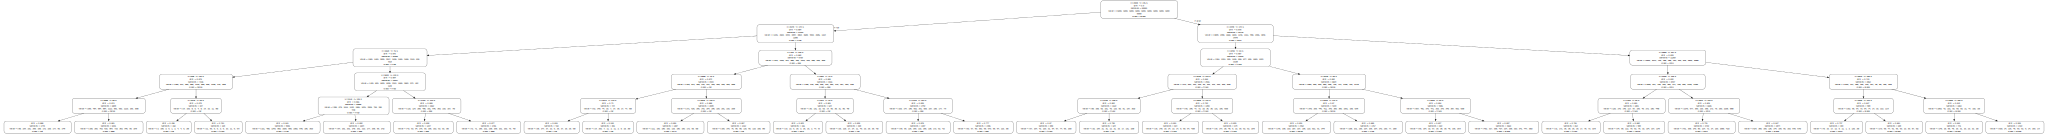

In [0]:
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
export_graphviz(model, rounded=True,class_names = classes,out_file='graph.dot')
dot_data = export_graphviz(model, rounded=True,class_names = classes)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"120,120!"')
graph.write_png('tree.png')
with open('graph.dot') as f:
  dot_graph = f.read()
graphviz.Source(dot_graph)

In [0]:
def plot_matrix_grid(V):
    """
    Given an array V containing stacked matrices, plots them in a grid layout.
    V should have shape (K,M,N) where V[k] is a matrix of shape (M,N).
    """
    assert V.ndim == 3, "Expected V to have 3 dimensions, not %d" % V.ndim
    k, m, n = V.shape
    ncol = 8                                     # At most 8 columns
    nrow = min(4, (k + ncol - 1) // ncol)        # At most 4 rows
    V = V[:nrow*ncol]                            # Focus on just the matrices we'll actually plot
    figsize = (2*ncol, max(1, 2*nrow*(m/n)))     # Guess a good figure shape based on ncol, nrow
    fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=figsize)
    vmin, vmax = np.percentile(V, [0.1, 99.9])   # Show the main range of values, between 0.1%-99.9%
    for v, ax in zip(V, axes.flat):
        img = ax.matshow(v, vmin=vmin, vmax=vmax, cmap=plt.get_cmap('gray'))
        ax.set_xticks([])
        ax.set_yticks([])
    fig.colorbar(img, cax=fig.add_axes([0.92, 0.25, 0.01, .5]))   # Add a colorbar on the right

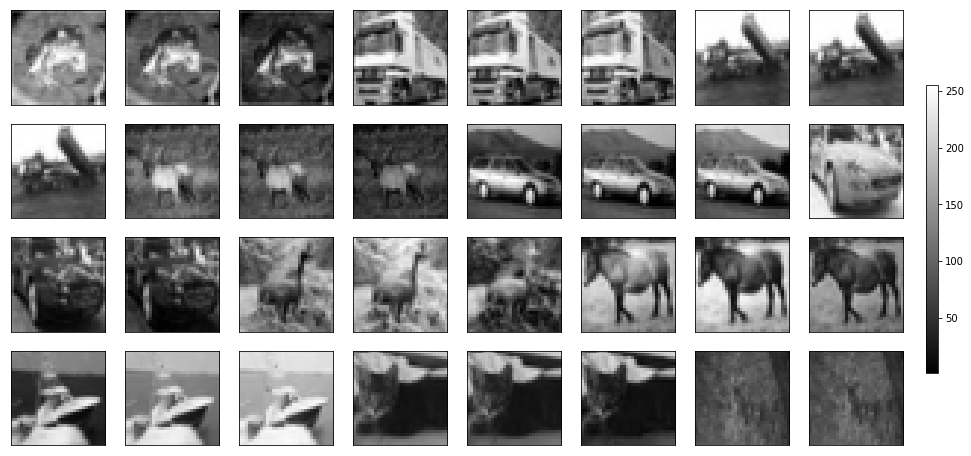

In [0]:
plot_matrix_grid(X_train.reshape(-1,32,32))

In [0]:
X_train = X_train / 255
X_test = X_test / 255
X_train = X_train.reshape(-1,3,32,32)
X_test = X_test.reshape(-1,3,32,32)
X_train_torch = torch.tensor(X_train.astype(np.float32))
y_train_torch = torch.tensor(y_train.astype(np.int64))
y_test_torch = torch.tensor(y_test.astype(np.int64))
X_test_torch = torch.tensor(X_test.astype(np.float32))

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 18, 5)
        self.fc1 = nn.Linear(18 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 18 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [0]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
batch_size=100
num_epoch = 20

In [0]:
for epoch in range(1,num_epoch+1):
    for i in range(0,len(X_train),batch_size):
        X = X_train_torch[i:i+batch_size]
        y = y_train_torch[i:i+batch_size]
        optimizer.zero_grad()
        y_pred = net(X)
        l = loss(y_pred,y)
        
       
        l.backward()
        optimizer.step()
    print("Epoch %d final minibatch had loss %.4f" % (epoch, l.item()))

Epoch 1 final minibatch had loss 2.0195
Epoch 2 final minibatch had loss 1.5893
Epoch 3 final minibatch had loss 1.4541
Epoch 4 final minibatch had loss 1.4016
Epoch 5 final minibatch had loss 1.3251
Epoch 6 final minibatch had loss 1.2383
Epoch 7 final minibatch had loss 1.2006
Epoch 8 final minibatch had loss 1.1713
Epoch 9 final minibatch had loss 1.0915
Epoch 10 final minibatch had loss 1.0580
Epoch 11 final minibatch had loss 0.9574
Epoch 12 final minibatch had loss 0.8951
Epoch 13 final minibatch had loss 0.9597
Epoch 14 final minibatch had loss 0.9237
Epoch 15 final minibatch had loss 0.8134
Epoch 16 final minibatch had loss 0.8666
Epoch 17 final minibatch had loss 0.9951
Epoch 18 final minibatch had loss 0.9152
Epoch 19 final minibatch had loss 0.8078
Epoch 20 final minibatch had loss 0.7964


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for i in range(0,len(X_test),batch_size):
        xt = X_test_torch[i:i+batch_size]
        yt = y_test_torch[i:i+batch_size]
        outputs = net(xt)
        _, predicted = torch.max(outputs.data, 1)
        total += yt.size(0)
        correct += (predicted == yt).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 58 %


In [0]:
# Save the model and plot
torch.save(net.state_dict(),'conv_net_model.ckpt')

In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for i in range(0,len(X_test),batch_size):
        xt = X_test_torch[i:i+batch_size]
        yt = y_test_torch[i:i+batch_size]
        outputs = net(xt)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == yt).squeeze()
        for i in range(4):
            label = yt[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 75 %
Accuracy of  bird : 39 %
Accuracy of   cat : 44 %
Accuracy of  deer : 46 %
Accuracy of   dog : 28 %
Accuracy of  frog : 75 %
Accuracy of horse : 78 %
Accuracy of  ship : 64 %
Accuracy of truck : 68 %


In [0]:
outputs.shape

torch.Size([100, 10])

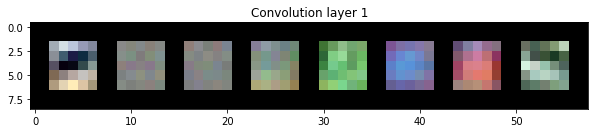

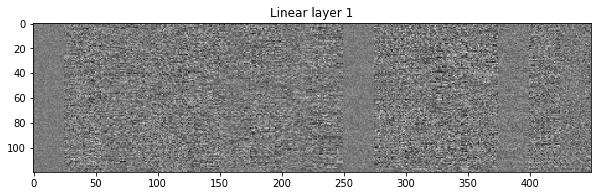

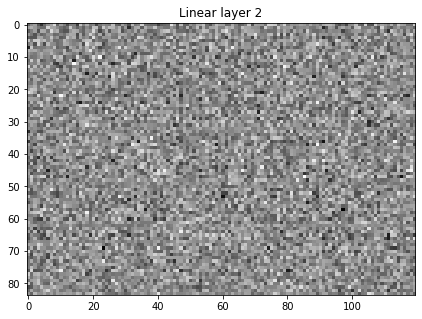

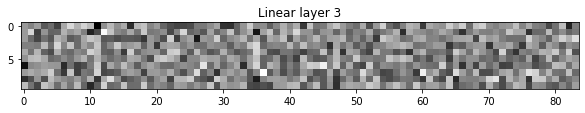

In [0]:

from torchvision.utils import make_grid

def scale_kernel(kernels):
  kernels = kernels - kernels.min()
  kernels = kernels / kernels.max()
  return kernels

kernel4 = scale_kernel(net.fc3.weight.detach().clone())
kernel3 = scale_kernel(net.fc2.weight.detach().clone())
kernel2 = scale_kernel(net.fc1.weight.detach().clone())
kernel1 = scale_kernel(net.conv1.weight.detach().clone())

kernels = [kernel1,kernel2,kernel3,kernel4]
# print(kernels.size())
for i in range(4):
  img = make_grid(kernels[i])
  plt.figure(figsize=(10,5))
  plt.imshow(img.permute(1, 2, 0))
  if i == 0:
    plt.title('Convolution layer 1')
  else:
    plt.title('Linear layer %d'%i)

car


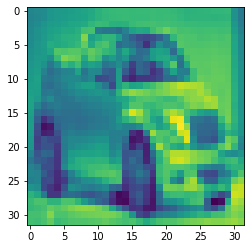

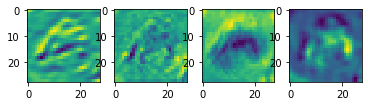

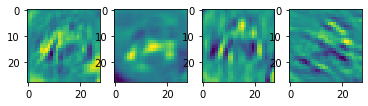

In [0]:
# normalizing the output
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

# Plot some images
idx = torch.randint(0, outputs.size(0), ()) 
img = X_train_torch[idx, 0]
plt.imshow(img.detach().numpy())
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

net.conv1.register_forward_hook(get_activation('conv1'))
data = X_train_torch[0]
data.unsqueeze_(0)
output = net(data)
_, predicted = torch.max(outputs, 1)
print(classes[predicted[5]])
act = activation['conv1'].squeeze()

j = 0
# images after applying convolutional layer 1 'conv1'
for i in range(2):
  f,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,sharex=True)
  ax1.imshow(act[j])
  ax2.imshow(act[j+1])
  ax3.imshow(act[j+2])
  ax4.imshow(act[j+3])

  j = j+4